**Pavlos Spanoudakis (sdi1800184)**\
**Theodora Troizi (sdi1800197)**
### Homework 2 on Data Mining Techniques class
## Goodreads Books Recommendation & Classification

In [1]:
### Standard Modules ###

# Type Hints
from typing import Iterable, List
# from typing_extensions import ParamSpec

import ast
# from datetime import datetime, date, timedelta
# from enum import Enum, auto
# import warnings


### Non-standard Modules ###

import pandas as pd
import numpy as np
# import seaborn as sns
# matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.axes3d import Axes3D
# sklearn
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans, AgglomerativeClustering
# ipynb-specific
from IPython.display import display, Markdown
# from tqdm.notebook import tqdm

In [2]:
CSV_PATH = '/books_1.Best_Books_Ever.csv'
USE_GDRIVE = True

def readDataset() -> pd.DataFrame:
    """
        Attempts to read the Dataset from `CSV_PATH`, unless `USE_GDRIVE` is `True`.
        If this is the case and this notebook is running on Google Colab (`google.colab` module is available),
        `CSV_PATH` should be set to a relative path under `/content/gdrive/My Drive/`.
    """

    path = '.'
    if USE_GDRIVE:
        try:
            from google.colab import drive # type: ignore
            drive.mount('/content/gdrive', force_remount=True)
            path = '/content/gdrive/My Drive/'
        except ImportError:
            pass
    
    path += CSV_PATH
    return pd.read_csv(path)

class DataColumn:
    """ Autocomplete (& typo prevention) helper for Column Titles. """

    BOOKID = 'bookId'
    TITLE = 'title'
    SERIES = 'series'
    AUTHOR = 'author'
    RATING = 'rating'
    DESCRIPTION = 'description'
    LANGUAGE = 'language'
    ISBN = 'isbn'
    GENRES = 'genres'
    CHARACTERS = 'characters'
    BOOKFORMAT = 'bookFormat'
    EDITION = 'edition'
    PAGES = 'pages'
    PUBLISHER = 'publisher'
    PUBLISHDATE = 'publishDate'
    FIRSTPUBLISHDATE = 'firstPublishDate'
    AWARDS = 'awards'
    NUMRATINGS = 'numRatings'
    RATINGSBYSTARS = 'ratingsByStars'
    LIKEDPERCENT = 'likedPercent'
    SETTING = 'setting'
    COVERIMG = 'coverImg'
    BBESCORE = 'bbeScore'
    BBEVOTES = 'bbeVotes'
    PRICE = 'price'
    RATINGSTAR1 = 'ratingStar1'
    RATINGSTAR2 = 'ratingStar2'
    RATINGSTAR3 = 'ratingStar3'
    RATINGSTAR4 = 'ratingStar4'
    RATINGSTAR5 = 'ratingStar5'

def printMd(s: str):
    """ Displays `s` as Markdown text in the output cell. """
    display(Markdown(s))

# TRet = TypeVar('TRet')
# TParams = ParamSpec('TParams')
# def runWithNoWarnings(fn: Callable[TParams, TRet], *args: TParams.args, **kwargs: TParams.kwargs) -> TRet:
#     """ Executes `fn` with the specified `*args` and `**kwargs` while ignoring any raised warnings. """
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore')
#         return fn(*args, **kwargs)

### Dataset Preprocessing

In [3]:
def printDatasetShape(dataset: pd.DataFrame):
    print(f'Dataset Shape:\nRows: {dataset.shape[0]}, Columns: {dataset.shape[1]}')

def getFilteredColumns(df: pd.DataFrame, colsToIgnore: Iterable[str]) -> List[str]:
    return [ c for c in df.columns if c not in colsToIgnore ]

def dropNaNRows(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    cols = getFilteredColumns(df, colsToIgnore)

    df.dropna(subset=cols, inplace=True)
    df.drop(df[df[DataColumn.RATINGSBYSTARS] == '[]'].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

def countMissingByColumn(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Returns a `DataFrame` which includes one row for each column of `df` with at least one missing value.
        
        Each row contains the name of the respective column, as well as the amount of missing values for that column.
    """

    cols = getFilteredColumns(df, colsToIgnore)
    temp = df[cols].isnull().sum().sort_values(ascending=False)
    missingDf = pd.DataFrame(temp.loc[temp > 0])
    missingDf.columns = ['Missing']
    return missingDf

In [4]:
dataDf = readDataset()
printDatasetShape(dataDf)

colsToIgnore = [
    DataColumn.EDITION,
    DataColumn.SERIES,
    DataColumn.FIRSTPUBLISHDATE,
    DataColumn.PRICE,
    DataColumn.BOOKFORMAT,
    DataColumn.LIKEDPERCENT,
    DataColumn.COVERIMG,
    DataColumn.CHARACTERS
]
countMissingByColumn(dataDf, colsToIgnore)

Dataset Shape:
Rows: 52478, Columns: 25


,Missing
language,3806
publisher,3696
pages,2347
description,1338
publishDate,880


In [5]:
dropNaNRows(dataDf, colsToIgnore)
printDatasetShape(dataDf)
countMissingByColumn(dataDf, colsToIgnore)

Dataset Shape:
Rows: 43388, Columns: 25


,Missing


In [6]:
class RatingStarColumns:
    
    starLabels = [
        DataColumn.RATINGSTAR5,
        DataColumn.RATINGSTAR4,
        DataColumn.RATINGSTAR3,
        DataColumn.RATINGSTAR2,
        DataColumn.RATINGSTAR1
    ]
    allLabels = starLabels + [DataColumn.RATINGSBYSTARS]

    @staticmethod
    def extractColumns(df: pd.DataFrame) -> pd.DataFrame:        
        for col in RatingStarColumns.starLabels:
            if col in df.columns:
                return df

        ratingStarArray = np.zeros(shape=(df.shape[0], len(RatingStarColumns.starLabels)), dtype=np.int)
        idxIter = iter(range(df.shape[0]))

        def addRatingStarRow(ratingsByStarsStr: str):
            idx = next(idxIter)
            ratingsList: Iterable[str] = ast.literal_eval(ratingsByStarsStr)
            for j, r in enumerate(ratingsList):
                ratingStarArray[idx][j] = int(r)

        df[DataColumn.RATINGSBYSTARS].apply(addRatingStarRow)

        temp = pd.DataFrame(columns=RatingStarColumns.starLabels, data=ratingStarArray)
        return pd.concat((df, temp), axis=1)
    
    @staticmethod
    def testRatings(df: pd.DataFrame):
        for _, row in df.iterrows():
            a: List[str] = ast.literal_eval(row[DataColumn.RATINGSBYSTARS])
            b = [str(row[col]) for col in (RatingStarColumns.starLabels)]
            if a != b:
                raise AssertionError(f'{a} != {b}')

dataDf = RatingStarColumns.extractColumns(dataDf)
RatingStarColumns.testRatings(dataDf)
dataDf[RatingStarColumns.allLabels].head()

,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1,ratingsByStars
0,3444695,1921313,745221,171994,93557,"['3444695', '1921313', '745221', '171994', '93..."
1,1593642,637516,222366,39573,14526,"['1593642', '637516', '222366', '39573', '14526']"
2,2363896,1333153,573280,149952,80794,"['2363896', '1333153', '573280', '149952', '80..."
3,1617567,816659,373311,113934,76770,"['1617567', '816659', '373311', '113934', '767..."
4,1751460,1113682,1008686,542017,548674,"['1751460', '1113682', '1008686', '542017', '5..."


### Data Observation

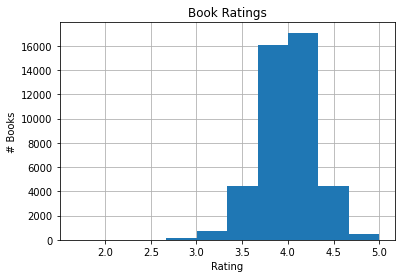

In [7]:
def displayColumnHistogram(df: pd.DataFrame, col: str, xlabel: str, ylabel: str = '# Books', title: str = ''):
    """
        Displays the Histogram for column `col` of `df`.
        - `xlabel`: the label for x-axis.
        - `ylabel`: the label for y-axis.
    """

    ax = plt.subplot()
    ax.set_title(title if title else col)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    df[col].hist(ax=ax, grid=True, zorder=3)

displayColumnHistogram(dataDf, col=DataColumn.RATING, xlabel='Rating', title='Book Ratings')